In [85]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
import math

if torch.cuda.is_available():
  dev = 'cuda'
  print("Cuda avaiable. Device used to train the model:", dev)
else: 
  dev = 'cpu'
  print("Cuda not avaiable. Device used to train the model:", dev)


Cuda not avaiable. Device used to train the model: cpu


# **A harmonic series dataset** (from: *sequential_things.ipynb* by **Franco Caspe**)

This dataset generates a periodic wave given a harmonic distribution and a number of cycles we want to compute.

In [17]:
# First version of HarmonicSeriesDataset
class HarmonicSeriesDataset(Dataset):
    
    def __init__(self, harmonics,n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        self.len = n_periods*2*harmonics.size()[0]
        self.sample_rate = 2*harmonics.size()[0]
        n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(n_freqs)
        self.freqs = torch.linspace(start=0, end=n_freqs-1, steps=n_freqs)
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample = 0
        
        self.phases += 2*np.pi*self.freqs/self.sample_rate
        sample = torch.sum(harmonics*torch.sin(self.phases))
        return sample

In [86]:
# Second version of HarmonicSeriesDataset
class HarmonicSeriesDataset(Dataset):
    
    def __init__(self, harmonics,n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        self.len = n_periods*2*harmonics.size()[0]
        self.sample_rate = 2*harmonics.size()[0]
        self.n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(self.n_freqs)
        self.freqs = torch.linspace(start=0, end=self.n_freqs-1, steps=self.n_freqs)
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
      input = torch.ones(self.len)
      delay = np.random.randint(0,self.len-2)
      input[0:delay] = 0
      output = torch.zeros(self.len)
      
      for i in range(self.len):   
#        if input[i] == 1:     
#          self.phases += (2*np.pi*self.freqs/self.sample_rate)
#        else:
#          self.phases = torch.zeros(self.n_freqs)
        self.phases += (2*np.pi*self.freqs/self.sample_rate)
        self.phases = self.phases * input[i]
        output[i] = torch.sum(harmonics*torch.sin(self.phases))*input[i]    
      return input, output

Let's generate a dataset and plot its content.

<ipython-input-86-20af67de22c8>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.harmonics = torch.tensor(harmonics)


240
240
Samples.shape: torch.Size([128, 240, 2])


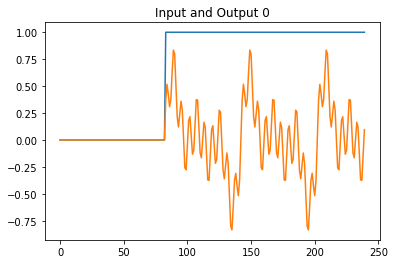

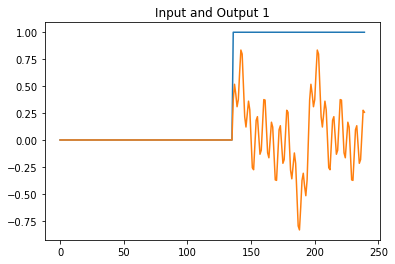

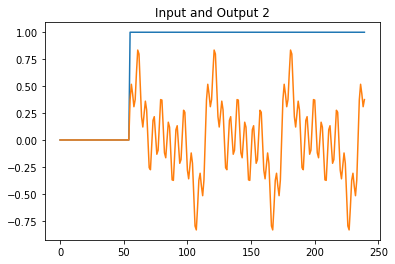

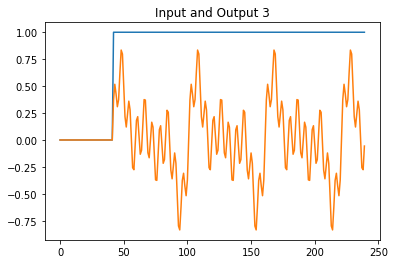

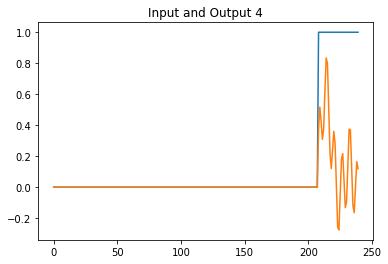

In [87]:
# Dataset configuration
period_len = 60
n_periods = 4
# Generate a distribution of harmonics
harmonics = torch.zeros(period_len//2)
harmonics[1] = 1
harmonics[2] = 1
harmonics[3] = 1
harmonics[10] = 1
# Normalize distribution
harmonics = harmonics/torch.sum(harmonics)

# Create dataset
batch_size = 128
dataset = HarmonicSeriesDataset(harmonics,n_periods)
dataloader = torch.utils.data.DataLoader(dataset)

# Sample storage to plot
signal_len = len(dataloader)
print(period_len*n_periods)
print(signal_len)

samples = torch.zeros(batch_size,signal_len,2)

#for i,sample in enumerate(dataloader):
#      samples[:,i] = sample

for i in range(batch_size):
  samples[i,:,0],samples[i,:,1] = next(iter(dataloader))


print("Samples.shape:",samples.shape)
for i in range(5):
  plt.plot(samples[i,:,0].detach().numpy())
  plt.plot(samples[i,:,1].detach().numpy())
  plt.title("Input and Output {}".format(i))
  plt.show()


# **A simple forecasting problem.** (from: *sequential_things.ipynb* by **Franco Caspe**)

Let's generate a dataset for the models to predict an output $A$ samples ahead.

torch.Size([128, 240, 2])


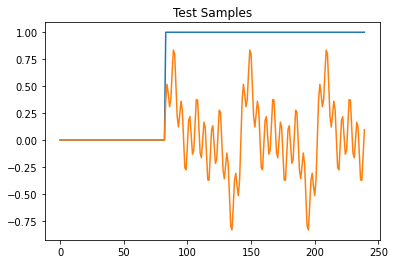

In [88]:
train_samples = samples
# test_samples = torch.roll(train_samples,A,2)
print(train_samples.shape)
plt.show()

fig, ax = plt.subplots()
ax.plot(train_samples[0,:,:].detach().cpu().numpy())
# ax.plot(test_samples.view(-1).detach().cpu().numpy())
plt.title("Test Samples")
plt.show()

# **Gated Recurrent Unit (GRU)**

In [89]:
class GRUmodel(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, num_layers=1):
    super(GRUmodel, self).__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    # GRU (input)
    self.gru = nn.GRU(input_size, hidden_dim, num_layers=num_layers, batch_first=True)
    # Fully connected (output)
    self.lin = nn.Linear(hidden_dim, output_size)
    
  # Forward method
  def forward(self, seq):

    input = seq  # input.shape = (N,L,input_size)
    
    out, hidden = self.gru(input) # out.shape = (L,hidden_dim)...hidden.shape = (num_layers, hidden_dim)
    out = self.lin(out) # out.shape = (1,1)
    return out


In [90]:
def gru_evaluate_on_data(net, eval_input, target, device, plot=False):

  L = target.shape[1] # sequence length
  batch_size = target.shape[0] # batch size
  random = np.random.randint(0,batch_size-2)
  target = target[random,:,:].unsqueeze(0).to(device) # ([N,L,1])
  # seq = torch.ones([batch_size,L,1]).to(device) # ([N,L,1])
  seq = eval_input[random,:,:].unsqueeze(0).to(device)

  with torch.no_grad():
    pred = net(seq)
      # Calculate evaluation loss
  eval_loss = torch.sum(torch.abs(target-pred))

  # Plotting results
  if(plot):
    fig, ax = plt.subplots()
    print("[TEST ON DATA] Eval loss {}".format(eval_loss))
    ax.plot(seq[0,:,:].detach().numpy())
    ax.plot(target[0,:,:].detach().numpy())
    ax.plot(pred[0,:,:].detach().numpy())
    plt.show()

  return eval_loss
  
def gru_train(net, epochs, train_samples, device):
  
  net.train()

  # Define Loss, Optimizer, ecc.
  criterion = nn.L1Loss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  best_eval_loss = np.inf

  target = train_samples[:,:,1].unsqueeze(2).to(device) #([N,L,1])
  train = train_samples[:,:,1].unsqueeze(2).to(device) #([N,L,1]) 
  L = target.shape[1] # sequence length
  n_batches = target.shape[0] # batch size
  epochs_loss = np.zeros(epochs)

  for epoch in range(epochs): 
    optimizer.zero_grad()
    running_loss = 0.0
    # seq = torch.ones([n_batches,L,1]).to(device) # ([N,L,1])
    seq = train_samples[:,:,0].unsqueeze(2).to(device)
    prediction = net(seq)
    loss = criterion(prediction, target) # Calculate loss
    loss.backward() # Backpropagation and calculates gradients
    optimizer.step() # Updates the weights
    # Print statistics
    running_loss += loss.item() # To calculate epochs' mean loss
    plot = True if (epoch%(epochs/16)==0) else False
    eval_loss = gru_evaluate_on_data(net, seq, target, device, plot=plot)
    
    epochs_loss[epoch] = eval_loss # For plotting loss during epochs

    if eval_loss < best_eval_loss:
      best_eval_loss = eval_loss
      torch.save(net.state_dict(), 'best_gru.pt')

    if (epoch%(epochs/20) == 0):
        print('Epoch: {}/{}.............'.format(epoch, epochs), end=' ')
        print("Train Loss: {:.4f} - Best Eval {:.4f}".format(running_loss, best_eval_loss))
    
    running_loss = 0.0

  print("---------- FINISHED TRAINING ----------")

  # Print Eval Loss
  x_ = np.linspace(0, epochs-1, epochs)
  y_ = epochs_loss
  yhat_ = signal.savgol_filter(y_, 101, 3) # Savitzky-Golay filter for smoothing

  fig, ax = plt.subplots()
  ax.plot(x_, y_)
  ax.plot(x_, yhat_)
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Eval Loss') 
  # ax.grid(True) 
  plt.show()

In [91]:
def train_and_test_GRU(hidden_size, n_hidden_layers, train_data, target, epochs, device):
  train_len = train_data.size()[2]

  net = GRUmodel(1,1,hidden_size, n_hidden_layers)
  net = net.to(device)

  model_parameters = filter(lambda p: p.requires_grad, net.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("[INFO] Number of parameters: {}".format(params))
  
  # TRAINING
  gru_train(net, epochs, train_samples, device)

  # TEST
  net.load_state_dict(torch.load('best_gru.pt'))  
  net.eval()
  target = train_samples[:,:,1].unsqueeze(2).to(device) #([N,L,1])
  input = train_samples[:,:,0].unsqueeze(2).to(device)
  gru_evaluate_on_data(net, input, target, device, plot=True)

  return net

[INFO] Number of parameters: 12929
[TEST ON DATA] Eval loss 59.86127471923828


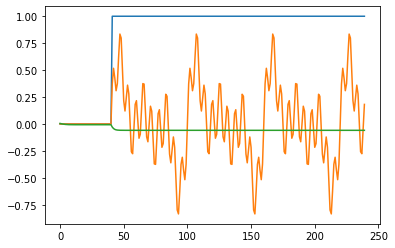

Epoch: 0/5000............. Train Loss: 0.1589 - Best Eval 59.8613
Epoch: 250/5000............. Train Loss: 0.1363 - Best Eval 0.9030
Epoch: 500/5000............. Train Loss: 0.1322 - Best Eval 0.4474
[TEST ON DATA] Eval loss 12.713887214660645


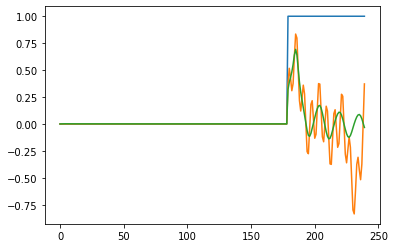

Epoch: 750/5000............. Train Loss: 0.1274 - Best Eval 0.4474
Epoch: 1000/5000............. Train Loss: 0.1166 - Best Eval 0.3577
[TEST ON DATA] Eval loss 45.910614013671875


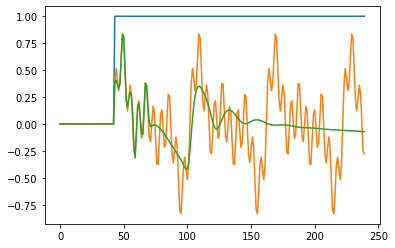

Epoch: 1250/5000............. Train Loss: 0.1019 - Best Eval 0.3386
Epoch: 1500/5000............. Train Loss: 0.0978 - Best Eval 0.2908
Epoch: 1750/5000............. Train Loss: 0.0868 - Best Eval 0.2779
[TEST ON DATA] Eval loss 4.6840386390686035


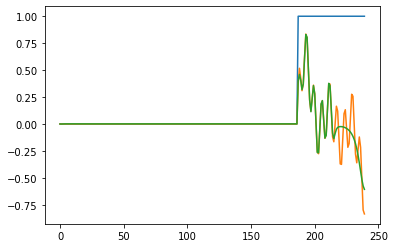

Epoch: 2000/5000............. Train Loss: 0.0862 - Best Eval 0.2779
Epoch: 2250/5000............. Train Loss: 0.0922 - Best Eval 0.1692
[TEST ON DATA] Eval loss 21.4067440032959


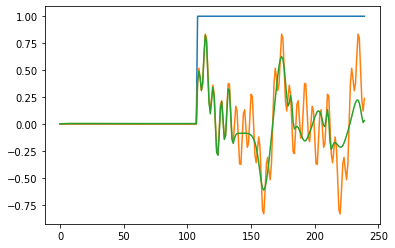

Epoch: 2500/5000............. Train Loss: 0.0892 - Best Eval 0.1662
Epoch: 2750/5000............. Train Loss: 0.0659 - Best Eval 0.1567
Epoch: 3000/5000............. Train Loss: 0.0682 - Best Eval 0.1567
[TEST ON DATA] Eval loss 17.806623458862305


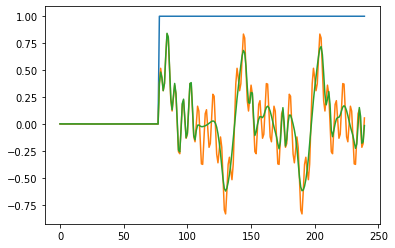

Epoch: 3250/5000............. Train Loss: 0.0514 - Best Eval 0.1078
Epoch: 3500/5000............. Train Loss: 0.0504 - Best Eval 0.0930
[TEST ON DATA] Eval loss 16.280607223510742


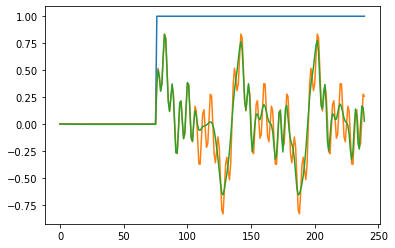

Epoch: 3750/5000............. Train Loss: 0.0442 - Best Eval 0.0930
Epoch: 4000/5000............. Train Loss: 0.0350 - Best Eval 0.0930
Epoch: 4250/5000............. Train Loss: 0.0212 - Best Eval 0.0930
[TEST ON DATA] Eval loss 2.7659969329833984


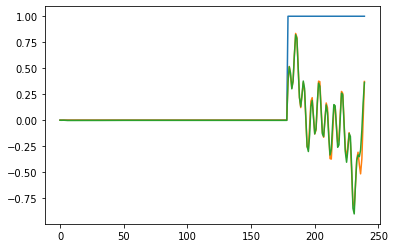

Epoch: 4500/5000............. Train Loss: 0.0162 - Best Eval 0.0899
Epoch: 4750/5000............. Train Loss: 0.0121 - Best Eval 0.0863
---------- FINISHED TRAINING ----------


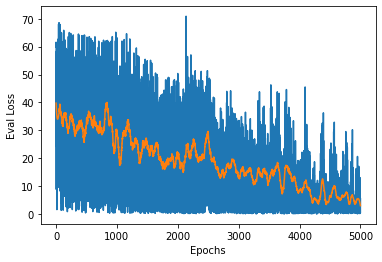

[TEST ON DATA] Eval loss 10.501799583435059


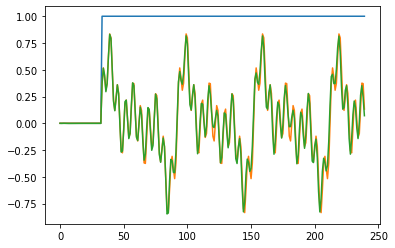

In [92]:
GRUnet = train_and_test_GRU(hidden_size=64, n_hidden_layers=1, train_data=train_samples, target=train_samples, epochs=5000, device=dev)

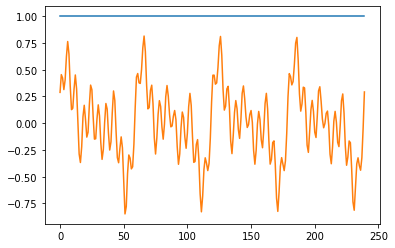

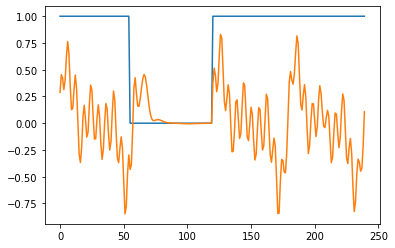

In [95]:
seq = torch.ones(1,240,1)
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().numpy())
plt.plot(signal[0,:,:].detach().numpy())
plt.show()

seq = torch.ones(1,240,1)
seq[:,55:120,:] = 0
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().numpy())
plt.plot(signal[0,:,:].detach().numpy())
plt.show()

In [ ]:
seq = torch.

In [ ]:
train_and_test_GRU(hidden_size=128, n_hidden_layers=1, train_data=train_samples, target=train_samples, epochs=5000, device=dev)

In [ ]:
train_and_test_GRU(hidden_size=64, n_hidden_layers=1, train_data=train_samples, target=train_samples, epochs=10000, device=dev)

In [ ]:
train_and_test_GRU(hidden_size=128, n_hidden_layers=1, train_data=train_samples, target=train_samples, epochs=10000, device=dev)

In [ ]:
train_and_test_GRU(hidden_size=32, n_hidden_layers=1, train_data=train_samples, target=train_samples, epochs=10000, device=dev)

In [ ]:
train_and_test_GRU(hidden_size=32, n_hidden_layers=1, train_data=train_samples, target=train_samples, epochs=20000, device=dev)

In [ ]:
train_and_test_GRU(hidden_size=64, n_hidden_layers=2, train_data=train_samples, target=train_samples, epochs=5000, device=dev)